# Complete analysis
In this notebook we combine the results from `tapo-analysis-conf`1,2,3,4,5,6`.ipynb` to compute the measured total energy consumption of all pipeline configurations.

## pipeline configurations
Six pipeline configurations: conf-1, conf-2, conf-3, conf-4, conf-5, conf-6
Each pipeline config was run 4 times.

## time shifts
* We do not know/understand why there are time diffs between the start time in SIMPIPE and the surge times discovered/reported by the Tapo device.
* `simpipe_datetime_shift`provide overall best guess of the time shift. But this was just used initially. We rather rely on the measured diff for each measurement.
* `surge_time_diff` is the measured time diff between the start time of the Tapo energy surge identified, and what SIMPIPE provides as timestamp. (this is what we use to shift the data)


In [1]:
import pandas as pd
import numpy as np
from analysis_functions import get_time_periods, get_power_data, divide_power_data_into_step_periods, compute_relative_energy_usage, compute_baseline_stats

In [2]:
surge_time_diffs = pd.read_csv("./data_carbontracker/surge_time_diffs.dat", delim_whitespace=True, comment='#', header=0)

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/824877900.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  surge_time_diffs = pd.read_csv("./data_carbontracker/surge_time_diffs.dat", delim_whitespace=True, comment='#', header=0)


In [3]:
surge_time_diffs.head(4*6)

,configuration,runNr,startDiff,endDiff,duration
0,conf-1,1,138.9,118.9,205.1
1,conf-1,2,152.2,118.3,208.9
2,conf-1,3,123.0,118.6,204.4
3,conf-1,4,141.9,117.6,204.3
4,conf-2,1,135.4,115.3,200.1
5,conf-2,2,126.7,86.6,200.2
6,conf-2,3,150.1,109.9,200.2
7,conf-2,4,122.2,113.5,203.7
8,conf-3,1,152.2,119.2,198.0
9,conf-3,2,150.7,88.0,197.7


In [4]:
base_path = "./data_carbontracker"
datasets = {
    "conf-1": {
        "simpipe_datetime_shift": 112, # shift simpipe_data by this amount of minutes (from comparison_analysis.ipynb average Delta value)
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-09-01 00:00:00', 
            "end_time_baseline": '2025-09-01 06:00:00',
            "start_time_pipeline": '2025-09-01 06:21:04',
            "end_time_pipeline": '2025-09-01 09:46:07'
            },
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-09-01 13:00:00', 
            "end_time_baseline": '2025-09-01 20:00:40',
            "start_time_pipeline": '2025-09-01 21:07:47',
            "end_time_pipeline": '2025-09-02 00:36:43'
            },
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-09-02 00:00:00', 
            "end_time_baseline": '2025-09-02 05:00:00',
            "start_time_pipeline": '2025-09-02 05:26:59',
            "end_time_pipeline": '2025-09-02 08:51:24'
            },
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-08-28 00:00:00', 
            "end_time_baseline": '2025-08-28 09:00:00',
            "start_time_pipeline": '2025-08-28 14:19:24',
            "end_time_pipeline": '2025-08-28 18:43:57'
            },
    },
    "conf-2": {
        "simpipe_datetime_shift": 112, # shift simpipe_data by this amount of minutes (from comparison_analysis.ipynb average Delta value)        
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-2"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-08-31 03:00:00',
            "end_time_baseline": '2025-08-31 14:00:00',
            "start_time_pipeline": '2025-08-31 13:09:34',
            "end_time_pipeline": '2025-08-31 16:29:43'},
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-2"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-08-31 09:00:00', 
            "end_time_baseline": '2025-08-31 15:00:00',
            "start_time_pipeline": '2025-08-31 17:43:17',
            "end_time_pipeline": '2025-08-31 21:03:26'},
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-2"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-09-02 03:00:00', 
            "end_time_baseline": '2025-09-02 07:00:00',
            "start_time_pipeline": '2025-09-02 14:54:55',
            "end_time_pipeline": '2025-09-02 18:15:04'},
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-2"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-09-08 15:00:00', 
            "end_time_baseline": '2025-09-09 05:00:00',
            "start_time_pipeline": '2025-09-09 06:12:51',
            "end_time_pipeline": '2025-09-09 09:36:31'},
    },
    "conf-3": {
        "simpipe_datetime_shift": 112, # shift simpipe_data by this amount of minutes (from best guess startDiff)
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-3"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-08-30 15:00:00', 
            "end_time_baseline": '2025-08-30 19:00:00',
            "start_time_pipeline": '2025-08-30 19:57:50',
            "end_time_pipeline": '2025-08-30 23:15:49'},
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-3"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-09-03 04:00:00', 
            "end_time_baseline": '2025-09-03 06:00:00',
            "start_time_pipeline": '2025-09-03 06:24:19',
            "end_time_pipeline": '2025-09-03 09:42:00'},
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-3"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-09-08 19:00:00', 
            "end_time_baseline": '2025-09-09 03:00:00',
            "start_time_pipeline": '2025-09-09 12:52:27',
            "end_time_pipeline": '2025-09-09 16:15:40'},
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-3"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-09-09 19:00:00', 
            "end_time_baseline": '2025-09-09 20:30:00',
            "start_time_pipeline": '2025-09-09 21:11:27',
            "end_time_pipeline": '2025-09-10 00:30:22'},
    },
    "conf-4": {
        "simpipe_datetime_shift": 121.0, # shift simpipe_data by this amount of minutes (best guess startDiff)
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-4"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-09-10 03:00:00', 
            "end_time_baseline": '2025-09-10 05:30:00',
            "start_time_pipeline": '2025-09-10 06:03:58',
            "end_time_pipeline": '2025-09-10 08:05:41'},
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-4"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-08-29 11:30:00', 
            "end_time_baseline": '2025-08-29 13:00:00',
            "start_time_pipeline": '2025-08-29 13:37:05',
            "end_time_pipeline": '2025-08-29 15:37:11'},
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-4"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-08-30 00:00:00', 
            "end_time_baseline": '2025-08-30 07:30:00',
            "start_time_pipeline": '2025-08-30 08:19:09',
            "end_time_pipeline": '2025-08-30 10:19:40'},
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-4"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-09-10 11:00:00', 
            "end_time_baseline": '2025-09-10 19:00:00',
            "start_time_pipeline": '2025-09-10 19:53:05',
            "end_time_pipeline": '2025-09-10 21:53:41'},
    },
    "conf-5": {
        "simpipe_datetime_shift": 122.0, # shift simpipe_data by this best guess
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-5"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-09-11 18:00:00', 
            "end_time_baseline": '2025-09-12 06:30:00',
            "start_time_pipeline": '2025-09-12 07:01:00',
            "end_time_pipeline": '2025-09-12 11:25:11'},
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-5"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-09-12 21:00:00', 
            "end_time_baseline": '2025-09-13 12:30:00',
            "start_time_pipeline": '2025-09-13 12:52:13',
            "end_time_pipeline": '2025-09-13 17:17:05'},
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-5"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-09-14 01:00:00', 
            "end_time_baseline": '2025-09-14 11:30:00',
            "start_time_pipeline": '2025-09-14 11:54:17',
            "end_time_pipeline": '2025-09-14 16:18:06'},
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-5"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-09-14 19:00:00', 
            "end_time_baseline": '2025-09-15 06:45:00',
            "start_time_pipeline": '2025-09-15 07:15:49',
            "end_time_pipeline": '2025-09-15 11:45:42'},
    },
    "conf-6": {
        "simpipe_datetime_shift": 120.6,
        "run1": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-6"][surge_time_diffs.runNr == 1].values[0][2]),
            "start_time_baseline": '2025-09-04 00:00:00', 
            "end_time_baseline": '2025-09-04 11:00:00',
            "start_time_pipeline": '2025-09-04 11:15:16',
            "end_time_pipeline": '2025-09-04 13:14:15'},
        "run2": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-6"][surge_time_diffs.runNr == 2].values[0][2]),
            "start_time_baseline": '2025-09-11 00:30:00', 
            "end_time_baseline": '2025-09-11 06:30:00',
            "start_time_pipeline": '2025-09-11 06:59:23',
            "end_time_pipeline": '2025-09-11 08:56:30'},
        "run3": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-6"][surge_time_diffs.runNr == 3].values[0][2]),
            "start_time_baseline": '2025-09-11 11:30:00', 
            "end_time_baseline": '2025-09-11 12:30:00',
            "start_time_pipeline": '2025-09-11 13:02:39',
            "end_time_pipeline": '2025-09-11 15:00:56'},
        "run4": {
            "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-6"][surge_time_diffs.runNr == 4].values[0][2]),
            "start_time_baseline": '2025-09-05 15:00:00', 
            "end_time_baseline": '2025-09-05 21:00:00',
            "start_time_pipeline": '2025-09-05 21:48:22',
            "end_time_pipeline": '2025-09-05 23:45:25'},
    },
}

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/1369111000.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 1].values[0][2]),
/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/1369111000.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 2].values[0][2]),
/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/1369111000.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "surge_time_diff": float(surge_time_diffs[surge_time_diffs.configuration == "conf-1"][surge_time_diffs.runNr == 3].values[0][2]),
/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/1369111000.py:27: UserWarning: Boolean Series key will be reind

In [5]:
def analyze_data(
        simpipe_data: pd.DataFrame, 
        tapo_power_data: pd.DataFrame, 
        simpipe_datetime_shift: float = 0):
    """
    Analyze the data from the simulation pipe and Tapo power data.
    """
    if simpipe_datetime_shift != 0:
        simpipe_data = simpipe_data.copy()
        # Convert start and stop columns to datetime if they aren't already
        simpipe_data["start"] = pd.to_datetime(simpipe_data["start"])
        simpipe_data["stop"] = pd.to_datetime(simpipe_data["stop"])
        # Apply shift
        simpipe_data["start"] += pd.Timedelta(minutes=simpipe_datetime_shift)
        simpipe_data["stop"] += pd.Timedelta(minutes=simpipe_datetime_shift)
    
    tapo_time_periods = get_time_periods(simpipe_data) # NB! Must add start and end times for baseline if we should use this!
    tapo_baseline_stats = compute_baseline_stats(df=tapo_power_data, percentile_threshold=70, print_stats=True) # compute baseline stats automatically.
    tapo_segmented_power_data = divide_power_data_into_step_periods(tapo_time_periods, tapo_power_data)
    tapo_relative_energy_usage, tapo_baseline_energy, tapo_total_absolute_energy, tapo_total_relative_energy = compute_relative_energy_usage(tapo_segmented_power_data, tapo_time_periods,tapo_baseline_stats)
    return {
        "time_periods": tapo_time_periods,
        "tapo_segmented_power_data": tapo_segmented_power_data,
        "tapo_relative_energy_usage": tapo_relative_energy_usage,
        "tapo_baseline_energy": tapo_baseline_energy,
        "tapo_total_absolute_energy": tapo_total_absolute_energy,
        "tapo_total_relative_energy": tapo_total_relative_energy,
        "simpipe_data": simpipe_data,
        "simpipe_total_energy": simpipe_data["energy"].sum(),
        "simpipe_pipeline_duration": (simpipe_data["stop"] - simpipe_data["start"]).sum().total_seconds()
    }

In [17]:
# Compute results

results = {
    "conf-1": [],
    "conf-2": [],
    "conf-3": [],
    "conf-4": [],
    "conf-5": [],
    "conf-6": []
}
for confNr in ["conf-1", "conf-2", "conf-3", "conf-4", "conf-5", "conf-6"]:
    print()
    print(f"=== PROCESSING {confNr} ===")
    for runNr in ["run1", "run2", "run3", "run4"]:
        print()
        print(f"  --- Processing {runNr}...")
        path_simpipe_data = f"{base_path}/{confNr}/{runNr}.dat"
        path_tapo_data = f"{base_path}/{confNr}/power-{runNr}.xls"
        simpipe_data = pd.read_csv(path_simpipe_data, delim_whitespace=True, comment='#', header=0)
        if simpipe_data["energy"].dtype == 'object':
            raise ValueError(f"Invalid data type for energy column in {path_simpipe_data}")
        tapo_power_data = get_power_data(path_tapo_data) # get tapo power data
        #simpipe_datetime_shift = datasets[confNr]["simpipe_datetime_shift"]
        simpipe_datetime_shift = datasets[confNr][runNr]["surge_time_diff"]
        r = analyze_data(simpipe_data=simpipe_data, tapo_power_data=tapo_power_data, simpipe_datetime_shift=simpipe_datetime_shift)
        results[confNr].append({"confNr": confNr, "runNr": runNr, **r})


=== PROCESSING conf-1 ===

  --- Processing run1...
    get_time_periods -- start and end times NOT present. NO baseline step appended.
    get_time_periods -- extracted time periods:
      - trimming: 2025-09-01 08:39:58 to 2025-09-01 09:04:08
      - alignment-bwa: 2025-09-01 09:04:18 to 2025-09-01 11:29:10
      - mark-duplicates: 2025-09-01 11:29:20 to 2025-09-01 11:59:34
      - create-fasta-dict: 2025-09-01 11:59:44 to 2025-09-01 12:00:54
      - create-fasta-index: 2025-09-01 12:01:03 to 2025-09-01 12:01:52
      - base-quality-score: 2025-09-01 12:02:02 to 2025-09-01 12:05:01
     compute_baseline_stats -- Baseline analysis...
      Power threshold for baseline: 207.0 W
      Baseline periods: 210 out of 288 (72.9%)
      Mean baseline power: 202.9 W
      Median baseline power: 203.0 W
      Std baseline power: 2.2 W
      Power range: 199.0 - 207.0 W
      Mean baseline energy per period: 0.016908 kWh
      Total baseline energy: 3.5507 kWh


     divide_power_data_into_step

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/4026164917.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  simpipe_data = pd.read_csv(path_simpipe_data, delim_whitespace=True, comment='#', header=0)
/Users/gorans/Documents/Gnuplot/carbontracker/mainframe/analysis_functions.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '204.31666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats['filtered_data'].loc[stats['filtered_data']['Date'].idxmax(), 'Power(W)'] *= fraction
/Users/gorans/Documents/Gnuplot/carbontracker/mainframe/analysis_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determin

    get_time_periods -- start and end times NOT present. NO baseline step appended.
    get_time_periods -- extracted time periods:
      - trimming: 2025-09-10 21:54:59 to 2025-09-10 22:14:22
      - alignment: 2025-09-10 22:14:32 to 2025-09-10 23:28:45
      - mark-duplicates: 2025-09-10 23:28:55 to 2025-09-10 23:52:00
      - create-fasta-index: 2025-09-10 23:52:10 to 2025-09-10 23:53:08
      - base-quality-score: 2025-09-10 23:53:18 to 2025-09-10 23:55:35
     compute_baseline_stats -- Baseline analysis...
      Power threshold for baseline: 207.0 W
      Baseline periods: 212 out of 288 (73.6%)
      Mean baseline power: 203.3 W
      Median baseline power: 203.0 W
      Std baseline power: 2.2 W
      Power range: 195.0 - 207.0 W
      Mean baseline energy per period: 0.016940 kWh
      Total baseline energy: 3.5913 kWh


     divide_power_data_into_step_periods...
        Processing trimming...
            start: 2025-09-10 21:54:59, end: 2025-09-10 22:14:22
        Processing 

/Users/gorans/Documents/Gnuplot/carbontracker/mainframe/analysis_functions.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '183.73333333333332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats['filtered_data'].loc[stats['filtered_data']['Date'].idxmax(), 'Power(W)'] *= fraction
/Users/gorans/Documents/Gnuplot/carbontracker/mainframe/analysis_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outdf = pd.concat([outdf, new_row], ignore_index=True)
/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/4026164917.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprec

In [18]:
# Analyse the results
final_results = pd.DataFrame(
    columns=["conf", "tapo_baseline_energy_avg", "tapo_baseline_energy_std", "tapo_absolute_energy_avg", "tapo_absolute_energy_std", "tapo_relative_energy_avg", "tapo_relative_energy_std", "simpipe_energy_avg", "simpipe_energy_std", "simpipe_duration_avg", "simpipe_duration_std"]
)
final_results_details = pd.DataFrame(
    columns=["conf", "runNr", "tapo_baseline_energy", "tapo_total_relative_energy", "tapo_total_absolute_energy", "simpipe_total_energy", "simpipe_duration"]
)
print("=== Analysis of the results ==================================================================")
print("""
    Baseline Energy (BE) 
    Relative Tapo Energy (RE)
    Absolute Tapo Energy (AE)
    SIMPIPE Energy (SE)
    SIMPIPE Duration (SD)
""")
for conf in results:
    print()
    print(f"=== RESULTS FOR {conf} ==================================================================")
    print("    Run :    BE       RE       AE       SE       |   SD")
    print("-----------------------------------------------------------------------------------------")
    baseline_energies = [result['tapo_baseline_energy'] for result in results[conf]]
    tapo_relative_energies = [result['tapo_total_relative_energy'] for result in results[conf]]
    tapo_absolute_energies = [result['tapo_total_absolute_energy'] for result in results[conf]]
    simpipe_energies = [result['simpipe_total_energy'] for result in results[conf]]
    simpipe_durations = [result['simpipe_pipeline_duration'] for result in results[conf]]
    
    avg_baseline_energy = np.mean(baseline_energies)
    avg_tapo_absolute_energy = np.mean(tapo_absolute_energies)
    avg_tapo_relative_energy = np.mean(tapo_relative_energies)
    avg_simpipe_energy = np.mean(simpipe_energies)
    avg_simpipe_duration = np.mean(simpipe_durations)

    std_baseline_energy = np.std(baseline_energies)
    std_tapo_absolute_energy = np.std(tapo_absolute_energies)
    std_tapo_relative_energy = np.std(tapo_relative_energies)
    std_simpipe_energy = np.std(simpipe_energies)
    std_simpipe_duration = np.std(simpipe_durations)

    final_results = pd.concat([final_results, pd.DataFrame([{
        "conf": conf,
        "tapo_baseline_energy_avg": avg_baseline_energy,
        "tapo_baseline_energy_std": std_baseline_energy,
        "tapo_absolute_energy_avg": avg_tapo_absolute_energy,
        "tapo_absolute_energy_std": std_tapo_absolute_energy,
        "tapo_relative_energy_avg": avg_tapo_relative_energy,
        "tapo_relative_energy_std": std_tapo_relative_energy,
        "simpipe_energy_avg": avg_simpipe_energy,
        "simpipe_energy_std": std_simpipe_energy,
        "simpipe_duration_avg": avg_simpipe_duration,
        "simpipe_duration_std": std_simpipe_duration
    }])], ignore_index=True)

    for result in results[conf]:
        final_results_details = pd.concat([final_results_details, pd.DataFrame([{
            "conf": conf,
            "runNr": result['runNr'],
            "tapo_baseline_energy": result['tapo_baseline_energy'],
            "tapo_total_relative_energy": result['tapo_total_relative_energy'],
            "tapo_total_absolute_energy": result['tapo_total_absolute_energy'],
            "simpipe_total_energy": result['simpipe_total_energy'],
            "simpipe_duration": result['simpipe_pipeline_duration']
        }])], ignore_index=True)

        print(f"    {result['runNr']} : {result['tapo_baseline_energy']:.4f}    {result['tapo_total_relative_energy']:.4f}  {result['tapo_total_absolute_energy']:.4f}  {result['simpipe_total_energy']:.4f}     |   {avg_simpipe_duration:.1f} seconds (in {result['simpipe_pipeline_duration']/3600:.2f} hours)")
    print("-----------------------------------------------------------------------------------------")    
    print(f"    AVG : {avg_baseline_energy:.4f}    {avg_tapo_relative_energy:.4f}  {avg_tapo_absolute_energy:.4f}  {avg_simpipe_energy:.4f}     |   {avg_simpipe_duration:.1f} seconds (in {avg_simpipe_duration/3600:.2f} hours)")
    print(f"    STD : {std_baseline_energy:.4f}    {std_tapo_relative_energy:.4f}  {std_tapo_absolute_energy:.4f}  {std_simpipe_energy:.4f}     |   {std_simpipe_duration:.1f} seconds (in {std_simpipe_duration/3600:.2f} hours)")
    print("=========================================================================================")

=== Analysis of the results ==================================================================

    Baseline Energy (BE) 
    Relative Tapo Energy (RE)
    Absolute Tapo Energy (AE)
    SIMPIPE Energy (SE)
    SIMPIPE Duration (SD)


=== RESULTS FOR conf-1 ==================================================================
    Run :    BE       RE       AE       SE       |   SD
-----------------------------------------------------------------------------------------
    run1 : 0.0169    0.2773  0.9029  0.3846     |   12291.5 seconds (in 3.40 hours)
    run2 : 0.0170    0.2541  0.9504  0.3854     |   12291.5 seconds (in 3.47 hours)
    run3 : 0.0170    0.2994  0.9284  0.3861     |   12291.5 seconds (in 3.39 hours)
    run4 : 0.0173    0.2971  1.0082  0.3858     |   12291.5 seconds (in 3.39 hours)
-----------------------------------------------------------------------------------------
    AVG : 0.0171    0.2820  0.9475  0.3855     |   12291.5 seconds (in 3.41 hours)
    STD : 0.0002    0

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/3543196692.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, pd.DataFrame([{
/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_70287/3543196692.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results_details = pd.concat([final_results_details, pd.DataFrame([{


In [19]:
final_results

,conf,tapo_baseline_energy_avg,tapo_baseline_energy_std,tapo_absolute_energy_avg,tapo_absolute_energy_std,tapo_relative_energy_avg,tapo_relative_energy_std,simpipe_energy_avg,simpipe_energy_std,simpipe_duration_avg,simpipe_duration_std
0,conf-1,0.017058,0.000168,0.947455,0.038892,0.281977,0.018248,0.385451,0.000565,12291.50,113.544044
1,conf-2,0.017451,0.000831,0.983009,0.050275,0.303836,0.049539,0.363599,0.002650,12011.75,91.365680
2,conf-3,0.017649,0.000924,0.904375,0.067964,0.258591,0.039565,0.386308,0.002562,11917.50,133.668433
3,conf-4,0.017011,0.000096,0.471877,0.029704,0.114656,0.028912,0.274097,0.000686,7204.00,35.909609
4,conf-5,0.016979,0.000070,0.882710,0.011894,0.131414,0.006877,0.284822,0.000467,15901.50,147.523727
5,conf-6,0.016971,0.000062,0.440834,0.033344,0.080174,0.007083,0.282982,0.000312,7021.75,48.966187


In [20]:
final_results_details

,conf,runNr,tapo_baseline_energy,tapo_total_relative_energy,tapo_total_absolute_energy,simpipe_total_energy,simpipe_duration
0,conf-1,run1,0.016908,0.277266,0.902860,0.384558,12254.0
1,conf-1,run2,0.016983,0.254110,0.950417,0.385407,12486.0
2,conf-1,run3,0.016998,0.299419,0.928357,0.386060,12215.0
3,conf-1,run4,0.017343,0.297111,1.008186,0.385778,12211.0
4,conf-2,run1,0.017094,0.349181,1.032933,0.363314,11959.0
5,conf-2,run2,0.017001,0.330490,1.010540,0.360466,11959.0
6,conf-2,run3,0.018881,0.220624,0.900347,0.362824,11959.0
7,conf-2,run4,0.016829,0.315048,0.988217,0.367793,12170.0
8,conf-3,run1,0.017049,0.277771,0.959745,0.383330,11829.0
9,conf-3,run2,0.019220,0.195438,0.791250,0.385008,11811.0


In [21]:
final_results.to_csv("./data_carbontracker/final_results.csv", index=False)
final_results_details.to_csv("./data_carbontracker/final_results_details.csv", index=False)

In [22]:
final_results_details.tapo_baseline_energy.mean()

np.float64(0.017186350678857185)

In [23]:
final_results_details.tapo_total_relative_energy.mean()

np.float64(0.19510782161102716)

In [24]:
final_results_details.tapo_total_absolute_energy.mean()

np.float64(0.7717100115740742)

In [25]:
final_results_details.simpipe_total_energy.mean()

np.float64(0.329543125)

<Axes: xlabel='Run number', ylabel='Energy (Wh)'>

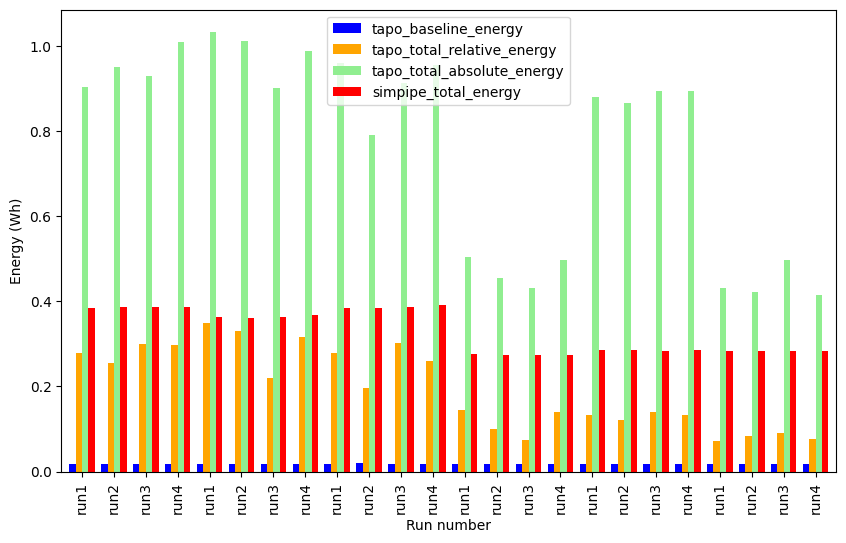

In [26]:
final_results_details.plot(x='runNr', y=['tapo_baseline_energy', 'tapo_total_relative_energy', 'tapo_total_absolute_energy', 'simpipe_total_energy'], kind='bar', ylabel="Energy (Wh)", xlabel="Run number", figsize=(10, 6), width=0.8, color=['blue', 'orange', 'lightgreen', 'red'])

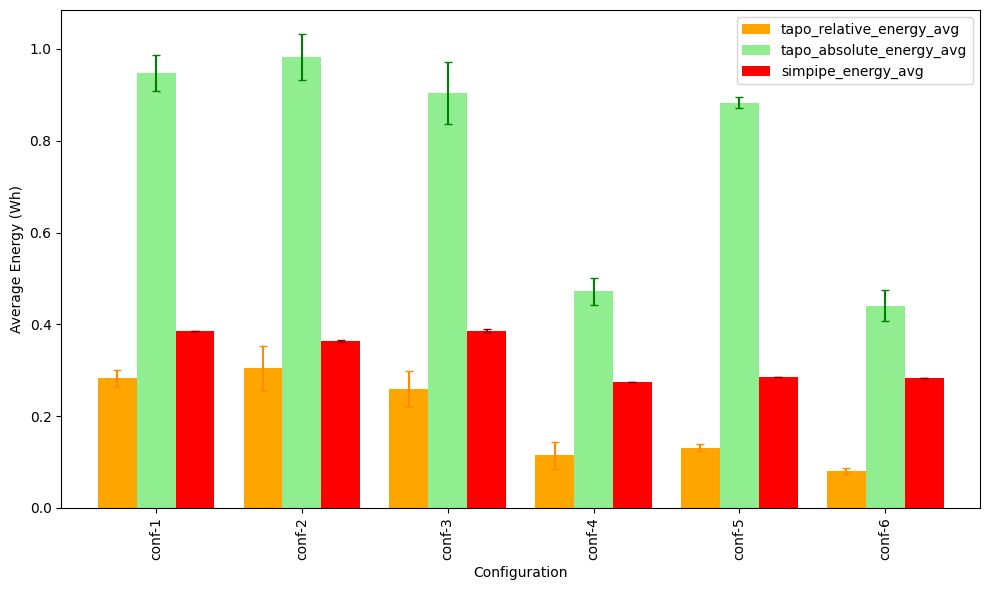

In [27]:
import matplotlib.pyplot as plt

# Create the bar plot
ax = final_results.plot(x='conf', y=['tapo_relative_energy_avg', 'tapo_absolute_energy_avg', 'simpipe_energy_avg'], 
                       kind='bar', ylabel="Average Energy (Wh)", xlabel="Configuration", 
                       figsize=(10, 6), width=0.8, color=['orange', 'lightgreen', 'red'])

# Add error bars
x_pos = np.arange(len(final_results))
width = 0.8 / 3  # width of each bar divided by number of series
#offset = width * 1.5  # offset for positioning bars

# Error bars for each series with correct positioning
ax.errorbar(x_pos - width, final_results['tapo_relative_energy_avg'], 
           yerr=final_results['tapo_relative_energy_std'], fmt='none', color='darkorange', capsize=3)
ax.errorbar(x_pos, final_results['tapo_absolute_energy_avg'], 
           yerr=final_results['tapo_absolute_energy_std'], fmt='none', color='green', capsize=3)
ax.errorbar(x_pos + width, final_results['simpipe_energy_avg'], 
           yerr=final_results['simpipe_energy_std'], fmt='none', color='darkred', capsize=3)

plt.tight_layout()
plt.show()